In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd

In [14]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect,and_

In [38]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [39]:
# reflect an existing database into a new model
base=automap_base()
# reflect the tables
base.prepare(engine,reflect=True)

In [40]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [41]:
# Save references to each table
Measurement=base.classes.measurement
Station=base.classes.station

In [42]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

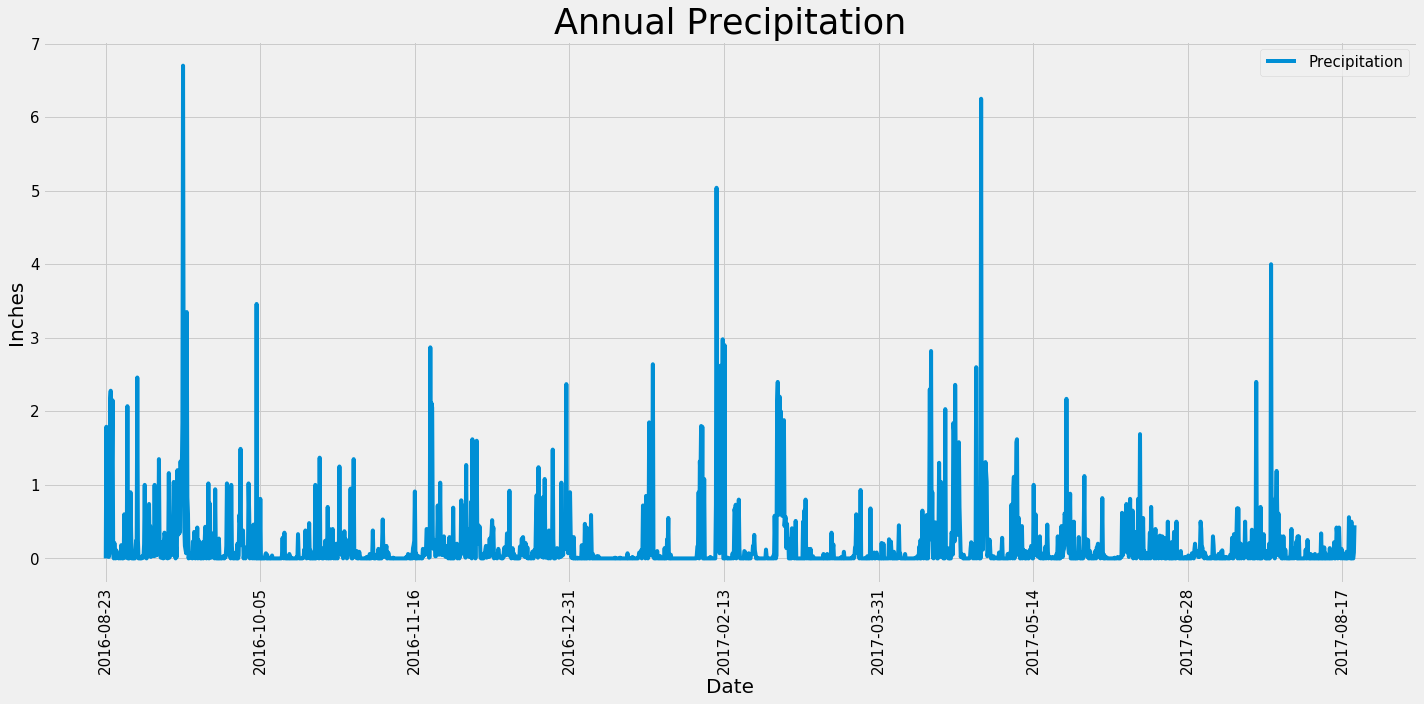

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_point=session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores
data=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=( dt.datetime.strptime(last_point[0],'%Y-%m-%d') - dt.timedelta(days=366))).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df=pd.DataFrame(data)
data_df=data_df.set_index("date")

# Sort the dataframe by date
sorted_df=data_df.sort_index().dropna(how='any')

# Use Pandas Plotting with Matplotlib to plot the data
pandas_bar=sorted_df.plot(figsize=(20,10))
plt.title("Annual Precipitation",fontSize=35)
plt.xticks(fontSize=15,rotation ="vertical")
plt.yticks(fontSize=15)
plt.ylabel("Inches",fontSize=20)
plt.xlabel("Date",fontSize=20)
plt.legend(["Precipitation"],fontsize=15)
plt.tight_layout()
plt.show()

In [44]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [45]:
# Design a query to show how many stations are available in this dataset
count_station=session.query(Measurement.station).distinct().count()
count_station

9

In [46]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
act_station=session.query(Measurement.station,func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
act_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
#TO DO DATA FRAME
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
result=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station==act_station[0][0]).all()
result


[(54.0, 85.0, 71.66378066378067)]

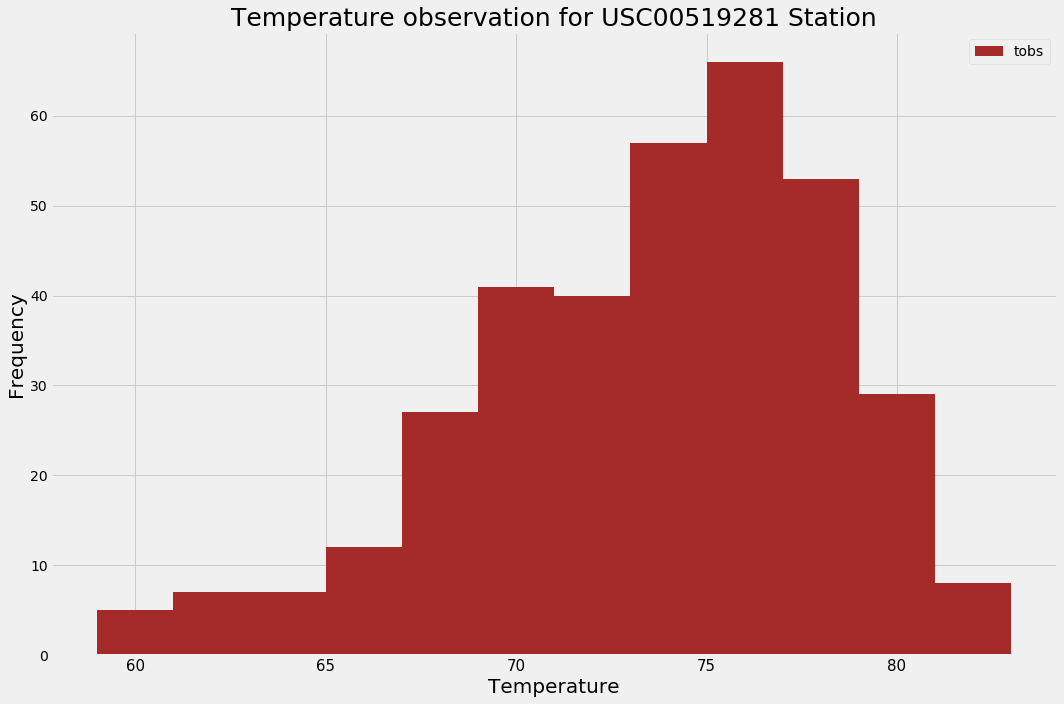

In [58]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data=session.query(Measurement.station,Measurement.tobs).filter(and_(Measurement.station=='USC00519281', Measurement.date>=( dt.datetime.strptime(last_point[0],'%Y-%m-%d') - dt.timedelta(days=366)))).all()
station_data_df=pd.DataFrame(station_data)
station_data_df=station_data_df.set_index('station')

station_data_df.plot.hist(bins=12,figsize=(15,10),color='brown')
plt.title("Temperature observation for USC00519281 Station",fontSize=25)
plt.xticks(fontSize=15)
plt.xlabel("Temperature",fontSize=20)
plt.ylabel("Frequency",fontSize=20)
plt.tight_layout()
plt.show()


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
